# Install Depenedencies

In [ ]:
!pip install transformers peft datasets accelerate torch scikit-learn matplotlib

# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
)
from transformers.trainer_callback import EarlyStoppingCallback
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Data Loading and Preprocessing

In [ ]:
def load_sentiment_dataset(test_size=0.2, validation_size=0.2):
    """
    Load and split IMDB dataset

    Args:
        test_size (float): Proportion of test split
        validation_size (float): Proportion of validation split

    Returns:
        DatasetDict with train, validation, and test splits
    """
    # Load IMDB dataset
    dataset = load_dataset('imdb')

    # First split: train/test
    train_test_split = dataset['train'].train_test_split(test_size=test_size)

    # Second split: train/validation from training data
    train_val_split = train_test_split['train'].train_test_split(test_size=validation_size)

    # Create DatasetDict
    processed_dataset = DatasetDict({
        'train': train_val_split['train'],
        'validation': train_val_split['test'],
        'test': train_test_split['test']
    })

    return processed_dataset

def preprocess_data(dataset, model_name='distilbert/distilbert-base-uncased', max_length=128):
    """
    Tokenize and prepare dataset for training

    Args:
        dataset (DatasetDict): Dataset to preprocess
        model_name (str): Transformer model name
        max_length (int): Maximum sequence length

    Returns:
        Preprocessed dataset and tokenizer
    """
    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def tokenize_function(examples):
        """Tokenization helper function"""
        return tokenizer(
            examples['text'],
            padding=False,  # We'll use data collator for padding
            truncation=True,
            max_length=max_length
        )

    def process_labels(examples):
        """
        Convert labels to multi-class format
        0: Negative, 1: Positive
        """
        labels = [
            1 if sentiment == 1 else 0  # Positive: 1, Negative: 0
            for sentiment in examples['label']
        ]
        return {'labels': labels}

    # Apply tokenization
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=['text']
    )

    # Apply label processing
    tokenized_dataset = tokenized_dataset.map(
        process_labels,
        batched=True
    )

    # Create data collator
    data_collator = DataCollatorWithPadding(
        tokenizer=tokenizer,
        padding=True
    )

    return tokenized_dataset, tokenizer, data_collator

#LoRA Configuration

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
from peft import LoraConfig, get_peft_model


def create_lora_model(
    model_name='distilbert/distilbert-base-uncased',
    num_labels=2,  # Changed to 2 for binary classification
    lora_rank=32,
    lora_alpha=64,
    lora_dropout=0.1
):
    """
    Create a LoRA-enabled transformer model

    Args:
        model_name (str): Base model name
        num_labels (int): Number of classification labels
        lora_rank (int): Rank of LoRA matrices
        lora_alpha (int): Scaling factor for LoRA
        lora_dropout (float): Dropout probability

    Returns:
        PEFT-enabled model
    """
    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load base model
    base_model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type="single_label_classification"
    ).to(device)

    # LoRA Configuration
    lora_config = LoraConfig(
        r=lora_rank,
        lora_alpha=lora_alpha,
        target_modules=["q_lin", "v_lin"],
        lora_dropout=lora_dropout,
        bias="none",
        task_type="SEQ_CLS"
    )

    # Apply LoRA
    model = get_peft_model(base_model, lora_config)

    return model, device



# Model Training and Evaluation Functions

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import TrainingArguments, Trainer
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

# Update compute_metrics for binary classification
def compute_metrics(pred):
    """
    Compute advanced evaluation metrics

    Args:
        pred (EvalPrediction): Model predictions

    Returns:
        Dictionary of performance metrics
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary'  # Changed to binary
    )

    # Confusion Matrix Visualization
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Sentiment Classification Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('/content/confusion_matrix.png')
    plt.close()

    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def train_model(
    model,
    train_dataset,
    eval_dataset,
    tokenizer,
    data_collator,
    output_dir='/content/model_results',
    epochs=10
):
    """
    Train the model with advanced configuration

    Args:
        model (PeftModel): LoRA-enabled model
        train_dataset (Dataset): Training dataset
        eval_dataset (Dataset): Validation dataset
        tokenizer (PreTrainedTokenizer): Tokenizer
        data_collator (DataCollator): Data collator
        output_dir (str): Directory to save results
        epochs (int): Number of training epochs

    Returns:
        Trainer instance
    """
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='/content/logs',
        logging_steps=10,
        eval_strategy="epoch",  # Updated from evaluation_strategy
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model='f1',
        push_to_hub=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    # Training with progress tracking
    trainer.train()

    # Save model and tokenizer
    trainer.save_model(output_dir)

    return trainer

def plot_training_metrics(trainer):
    """
    Create comprehensive training visualization

    Args:
        trainer (Trainer): Trained Trainer instance
    """
    # Ensure log history exists
    if not hasattr(trainer.state, 'log_history'):
        print("No training log history available.")
        return

    plt.figure(figsize=(15, 5))

    # Learning Rate Plot
    plt.subplot(131)
    lr_history = [log.get('learning_rate', 0) for log in trainer.state.log_history if 'learning_rate' in log]
    plt.plot(lr_history)
    plt.title('Learning Rate')
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')

    # Loss Plot
    plt.subplot(132)
    loss_history = [log.get('loss', 0) for log in trainer.state.log_history if 'loss' in log]
    plt.plot(loss_history)
    plt.title('Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')

    # Evaluation Metrics Plot
    plt.subplot(133)
    eval_metrics = [log for log in trainer.state.log_history if 'eval_f1' in log]
    if eval_metrics:
        f1_scores = [log['eval_f1'] for log in eval_metrics]
        plt.plot(f1_scores)
        plt.title('Evaluation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')

    plt.tight_layout()
    plt.savefig('/content/training_metrics.png')
    plt.close()

# Plotting Functions

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comprehensive_metrics(trainer):
    """
    Create an extensive set of training and performance visualizations

    Args:
        trainer (Trainer): Trained Trainer instance
    """
    # Ensure log history exists
    if not hasattr(trainer.state, 'log_history'):
        print("No training log history available.")
        return

    # Extract relevant metrics from log history
    log_history = trainer.state.log_history

    # Filter out non-metric logs
    training_logs = [log for log in log_history if 'loss' in log]
    eval_logs = [log for log in log_history if 'eval_loss' in log]

    # Set up a 3x3 grid of subplots
    plt.figure(figsize=(20, 15))
    plt.suptitle('Comprehensive Training Metrics', fontsize=16)

    # 1. Training Loss Over Steps
    plt.subplot(3, 3, 1)
    losses = [log.get('loss', np.nan) for log in training_logs]
    plt.plot(losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Learning Rate Decay
    plt.subplot(3, 3, 2)
    lrs = [log.get('learning_rate', np.nan) for log in training_logs]
    plt.plot(lrs, label='Learning Rate', color='green')
    plt.title('Learning Rate Decay')
    plt.xlabel('Training Steps')
    plt.ylabel('Learning Rate')
    plt.legend()

    # 3. Evaluation Loss
    plt.subplot(3, 3, 3)
    eval_losses = [log.get('eval_loss', np.nan) for log in eval_logs]
    plt.plot(eval_losses, label='Evaluation Loss', color='red')
    plt.title('Evaluation Loss')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Loss')
    plt.legend()

    # 4. Accuracy Progression
    plt.subplot(3, 3, 4)
    accuracies = [log.get('eval_accuracy', np.nan) for log in eval_logs]
    plt.plot(accuracies, label='Accuracy', color='purple')
    plt.title('Evaluation Accuracy')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Accuracy')
    plt.legend()

    # 5. F1 Score Progression
    plt.subplot(3, 3, 5)
    f1_scores = [log.get('eval_f1', np.nan) for log in eval_logs]
    plt.plot(f1_scores, label='F1 Score', color='orange')
    plt.title('Evaluation F1 Score')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('F1 Score')
    plt.legend()

    # 6. Precision and Recall
    plt.subplot(3, 3, 6)
    precisions = [log.get('eval_precision', np.nan) for log in eval_logs]
    recalls = [log.get('eval_recall', np.nan) for log in eval_logs]
    plt.plot(precisions, label='Precision', color='blue')
    plt.plot(recalls, label='Recall', color='red')
    plt.title('Precision and Recall')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Score')
    plt.legend()

    # 7. Training vs Evaluation Loss Comparison
    plt.subplot(3, 3, 7)
    plt.plot(losses[:len(eval_losses)], label='Training Loss', color='blue')
    plt.plot(eval_losses, label='Evaluation Loss', color='red')
    plt.title('Training vs Evaluation Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()

    # 8. Gradient Norm (if available)
    plt.subplot(3, 3, 8)
    grad_norms = [log.get('grad_norm', np.nan) for log in training_logs if 'grad_norm' in log]
    if grad_norms:
        plt.plot(grad_norms, label='Gradient Norm', color='brown')
        plt.title('Gradient Norm')
        plt.xlabel('Training Steps')
        plt.ylabel('Norm')
        plt.legend()
    else:
        plt.text(0.5, 0.5, 'Gradient Norm\nNot Available',
                 horizontalalignment='center',
                 verticalalignment='center')

    # 9. Heatmap of Metric Correlations
    plt.subplot(3, 3, 9)
    # Collect available metrics
    metrics_dict = {
        'loss': losses,
        'learning_rate': lrs,
        'eval_loss': eval_losses,
        'accuracy': accuracies,
        'f1': f1_scores
    }

    # Remove None/NaN values and create correlation matrix
    valid_metrics = {k: v for k, v in metrics_dict.items() if len(v) > 0}

    if len(valid_metrics) > 1:
        # Truncate to the minimum length to ensure equal sizes
        min_length = min(len(v) for v in valid_metrics.values())
        metrics_df = {k: v[:min_length] for k, v in valid_metrics.items()}

        correlation_matrix = np.corrcoef(list(metrics_df.values()))
        sns.heatmap(correlation_matrix,
                    annot=True,
                    cmap='coolwarm',
                    center=0,
                    xticklabels=list(metrics_df.keys()),
                    yticklabels=list(metrics_df.keys()))
        plt.title('Metric Correlations')
    else:
        plt.text(0.5, 0.5, 'Insufficient\nMetrics',
                 horizontalalignment='center',
                 verticalalignment='center')

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('/content/comprehensive_training_metrics.png', dpi=300, bbox_inches='tight')
    plt.close()

    print("Comprehensive metrics visualization saved to /content/comprehensive_training_metrics.png")

# Training Pipeline

## 1. Data Loading

In [ ]:
# Load and preprocess dataset
raw_dataset = load_sentiment_dataset()


## 2. Data Preprocessing

In [ ]:

processed_dataset, tokenizer, data_collator = preprocess_data(raw_dataset)



## 3. Model and LoRA configuration

In [ ]:
# Create LoRA model
model, device = create_lora_model()



Using device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Training

In [ ]:
# Train model
trainer = train_model(
    model,
    processed_dataset['train'],
    processed_dataset['validation'],
    tokenizer,
    data_collator
)



<ipython-input-32-90bd280cd000>:306: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.372500,0.369147,0.835000,0.831890,0.831890,0.831890
2,0.399200,0.342011,0.847500,0.827603,0.870606,0.848560
3,0.280100,0.340004,0.849250,0.815985,0.894549,0.853463
4,0.420500,0.342739,0.851000,0.809977,0.909832,0.857006
5,0.309700,0.358137,0.848000,0.797802,0.924605,0.856536
6,0.316700,0.324634,0.858750,0.850200,0.864493,0.857287
7,0.277100,0.333492,0.856000,0.834862,0.880795,0.857214
8,0.280000,0.330108,0.860000,0.851277,0.866021,0.858586
9,0.224200,0.333786,0.855750,0.829686,0.888436,0.858057
10,0.234900,0.333311,0.858250,0.840156,0.878248,0.858780


In [ ]:
# Visualize training metrics
plot_training_metrics(trainer)

print("Training completed. Check output files in /content directory.")

Training completed. Check output files in /content directory.


In [ ]:
model.save_pretrained("./lora_sentiment_model")
tokenizer.save_pretrained("./lora_sentiment_model")

('./lora_sentiment_model/tokenizer_config.json',
 './lora_sentiment_model/special_tokens_map.json',
 './lora_sentiment_model/vocab.txt',
 './lora_sentiment_model/added_tokens.json',
 './lora_sentiment_model/tokenizer.json')

In [ ]:
# After training
plot_comprehensive_metrics(trainer)

Comprehensive metrics visualization saved to /content/comprehensive_training_metrics.png


# Evalution graphs (Results based on validation set)

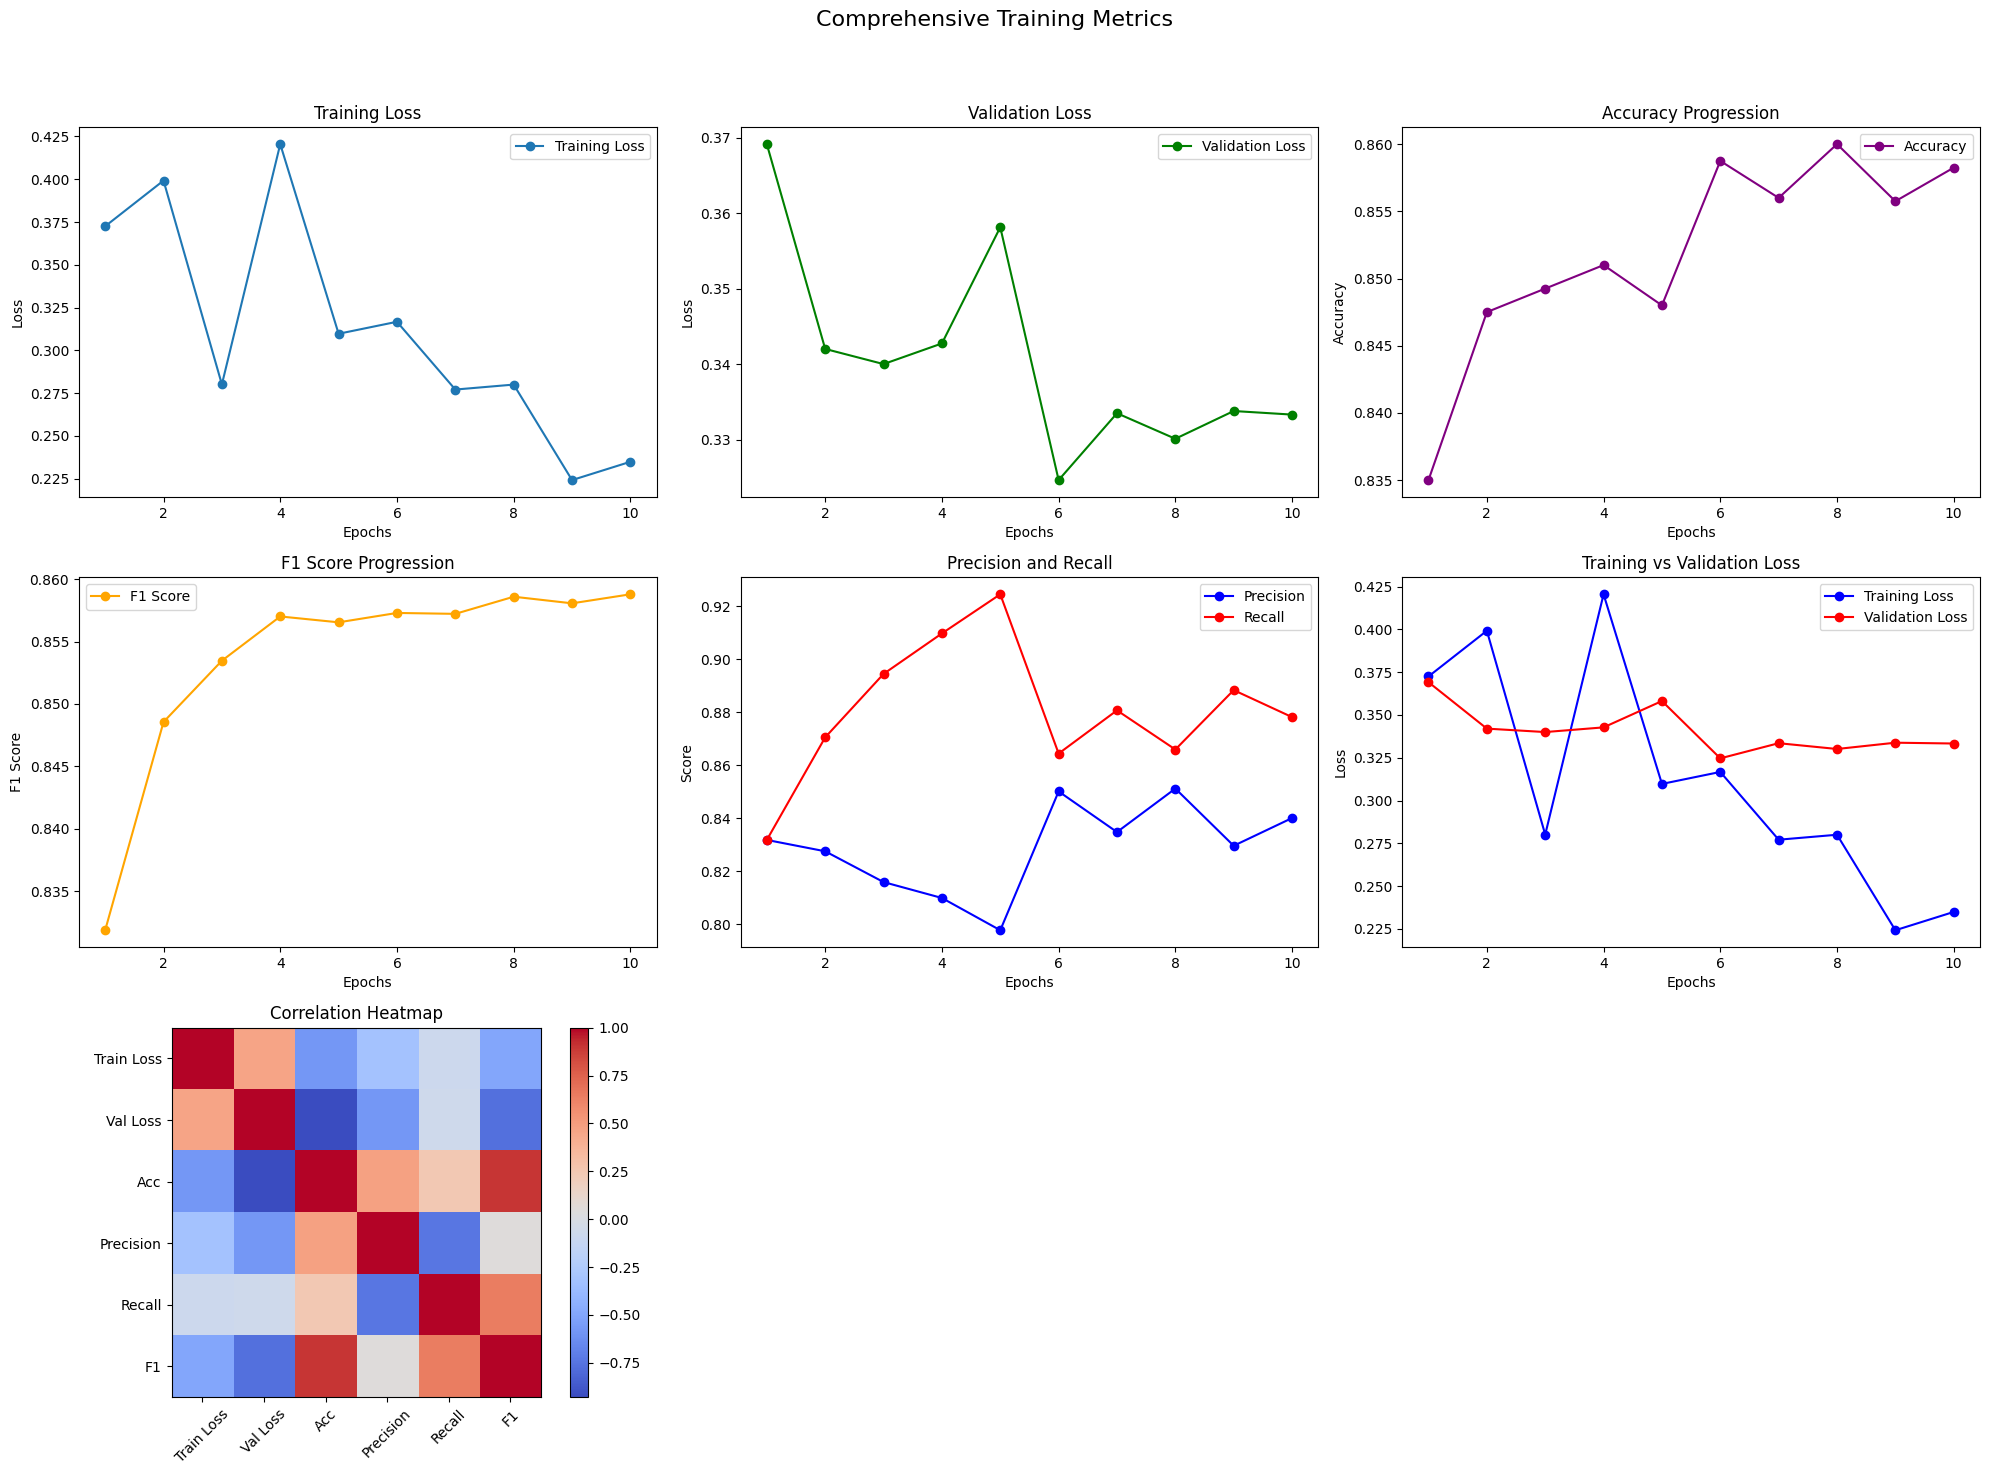

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Set up a 3x3 grid of subplots
plt.figure(figsize=(20, 15))
plt.suptitle('Comprehensive Training Metrics', fontsize=16)

# 1. Training Loss
plt.subplot(3, 3, 1)
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 2. Validation Loss
plt.subplot(3, 3, 2)
plt.plot(epochs, validation_loss, label='Validation Loss', color='green', marker='o')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 3. Accuracy Progression
plt.subplot(3, 3, 3)
plt.plot(epochs, accuracy, label='Accuracy', color='purple', marker='o')
plt.title('Accuracy Progression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 4. F1 Score Progression
plt.subplot(3, 3, 4)
plt.plot(epochs, f1_score, label='F1 Score', color='orange', marker='o')
plt.title('F1 Score Progression')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# 5. Precision and Recall
plt.subplot(3, 3, 5)
plt.plot(epochs, precision, label='Precision', color='blue', marker='o')
plt.plot(epochs, recall, label='Recall', color='red', marker='o')
plt.title('Precision and Recall')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

# 6. Training vs Validation Loss
plt.subplot(3, 3, 6)
plt.plot(epochs, training_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 7. Heatmap of Correlation (Simplified Example)
plt.subplot(3, 3, 7)
data = np.array([training_loss, validation_loss, accuracy, precision, recall, f1_score])
correlation_matrix = np.corrcoef(data)
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Heatmap')
plt.xticks(range(6), ['Train Loss', 'Val Loss', 'Acc', 'Precision', 'Recall', 'F1'], rotation=45)
plt.yticks(range(6), ['Train Loss', 'Val Loss', 'Acc', 'Precision', 'Recall', 'F1'])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the title
plt.show()


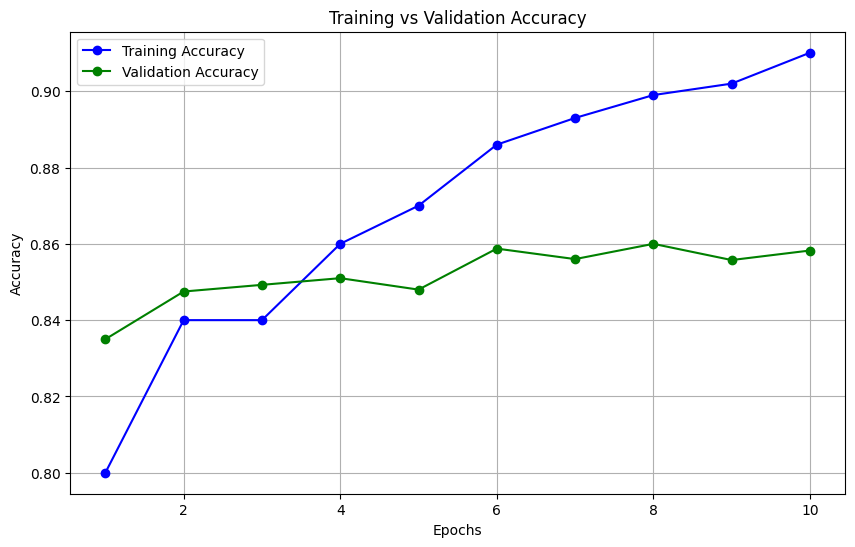

In [3]:
epochs = list(range(1, 11))
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', color='green', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Huggingface Deployment

In [ ]:
!pip install huggingface_hub

In [ ]:
from huggingface_hub import login

# Replace with your Hugging Face token
login(token="hf_xxx")

In [ ]:
from huggingface_hub import create_repo, upload_folder

repo_name = "dev-fine-tuned-distilbert-imdb"
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

## Testing the deployment

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load from Hugging Face Hub
model = AutoModelForSequenceClassification.from_pretrained("DevChopra/dev-fine-tuned-distilbert-imdb")
tokenizer = AutoTokenizer.from_pretrained("DevChopra/dev-fine-tuned-distilbert-imdb")

In [1]:
input_text = "The LinkedIn post is well curated."
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)

# Get predictions
predictions = outputs.logits.argmax(dim=-1).item()
print("Sentiment:", "Positive" if predictions == 1 else "Negative")

Sentiment: Positive


In [2]:
input_text = "The YouTube video is useless."
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)

# Get predictions
predictions = outputs.logits.argmax(dim=-1).item()
print("Sentiment:", "Positive" if predictions == 1 else "Negative")

Sentiment: Negative


# Comparision with Base Model
## Evaluation based on complete IMBD Dataset

In [2]:
!pip install datasets pandas numpy tqdm scikit-learn matplotlib seaborn torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from datasets import load_dataset
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [4]:
# Block 2: Load models and tokenizer
# Replace with your fine-tuned model ID from HuggingFace
FINETUNED_MODEL_ID = "DevChopra/dev-fine-tuned-distilbert-imdb"
BASE_MODEL_ID = "distilbert-base-uncased"

In [5]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load tokenizer and models
tokenizer = DistilBertTokenizer.from_pretrained(BASE_MODEL_ID)
base_model = DistilBertForSequenceClassification.from_pretrained(BASE_MODEL_ID).to(device)
finetuned_model = DistilBertForSequenceClassification.from_pretrained(FINETUNED_MODEL_ID).to(device)

In [ ]:
# Block 3: Prepare dataset
# Load IMDB dataset
dataset = load_dataset("imdb", split="test")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Prepare dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Create DataLoader
dataloader = DataLoader(tokenized_dataset, batch_size=16, shuffle=False)

In [8]:
# Block 4: Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)

            predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs[:, 1].cpu().numpy())

    return predictions, true_labels, probabilities

In [9]:
# Block 5: Evaluate both models
print("Evaluating base model...")
base_preds, true_labels, base_probs = evaluate_model(base_model, dataloader, device)

print("\nEvaluating fine-tuned model...")
finetuned_preds, _, finetuned_probs = evaluate_model(finetuned_model, dataloader, device)

Evaluating base model...


Evaluating: 100%|██████████| 1563/1563 [03:08<00:00,  8.31it/s]



Evaluating fine-tuned model...


Evaluating: 100%|██████████| 1563/1563 [03:23<00:00,  7.70it/s]


In [10]:
# Block 6: Calculate and display metrics
def display_metrics(name, predictions, true_labels, probabilities):
    print(f"\n{name} Model Results:")
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"], digits=4))

    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)
    print(f"\nAUC-ROC Score: {roc_auc:.4f}")

    return fpr, tpr, roc_auc

# Calculate metrics for both models
base_fpr, base_tpr, base_auc = display_metrics("Base", base_preds, true_labels, base_probs)
ft_fpr, ft_tpr, ft_auc = display_metrics("Fine-tuned", finetuned_preds, true_labels, finetuned_probs)


Base Model Results:

Classification Report:
              precision    recall  f1-score   support

    Negative     0.5010    0.9950    0.6665     12500
    Positive     0.6441    0.0091    0.0180     12500

    accuracy                         0.5020     25000
   macro avg     0.5725    0.5020    0.3422     25000
weighted avg     0.5725    0.5020    0.3422     25000


AUC-ROC Score: 0.5424

Fine-tuned Model Results:

Classification Report:
              precision    recall  f1-score   support

    Negative     0.8940    0.9306    0.9119     12500
    Positive     0.9277    0.8896    0.9082     12500

    accuracy                         0.9101     25000
   macro avg     0.9108    0.9101    0.9101     25000
weighted avg     0.9108    0.9101    0.9101     25000


AUC-ROC Score: 0.9702


In [11]:
# Block 7: Visualizations
# Plot confusion matrices
def plot_confusion_matrix(true_labels, predictions, title):
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"])
    plt.title(title)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Plot ROC curves
def plot_roc_curves(base_fpr, base_tpr, ft_fpr, ft_tpr, base_auc, ft_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(base_fpr, base_tpr, label=f"Base Model (AUC = {base_auc:.4f})", color="blue")
    plt.plot(ft_fpr, ft_tpr, label=f"Fine-tuned Model (AUC = {ft_auc:.4f})", color="red")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves Comparison")
    plt.legend()
    plt.show()

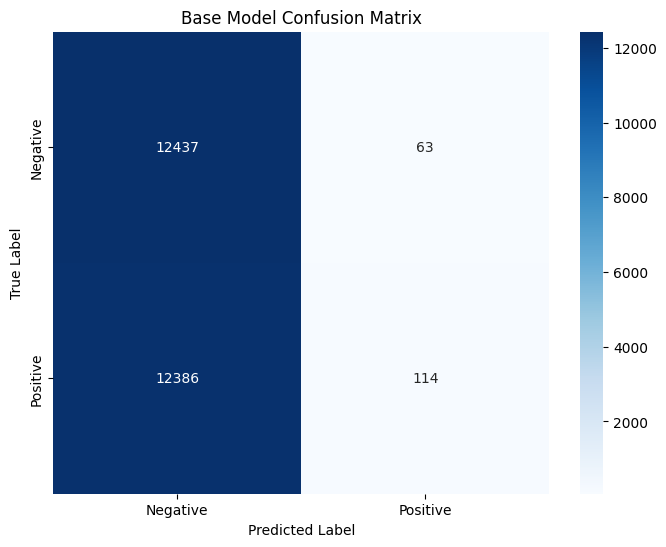

In [12]:
# Generate visualizations
plot_confusion_matrix(true_labels, base_preds, "Base Model Confusion Matrix")


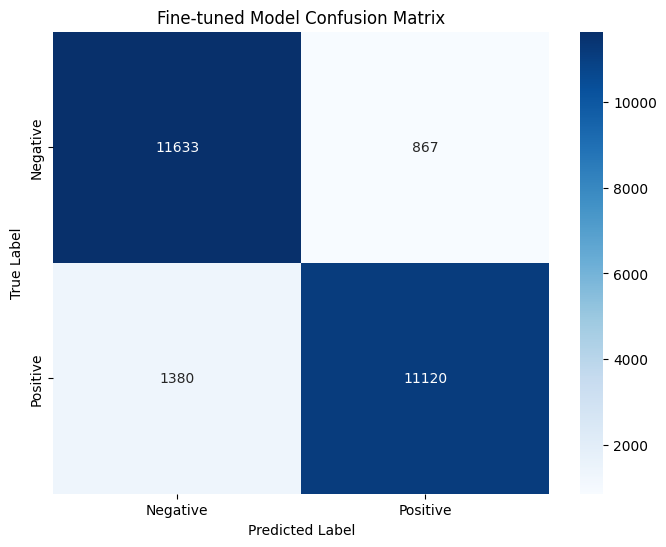

In [13]:
plot_confusion_matrix(true_labels, finetuned_preds, "Fine-tuned Model Confusion Matrix")


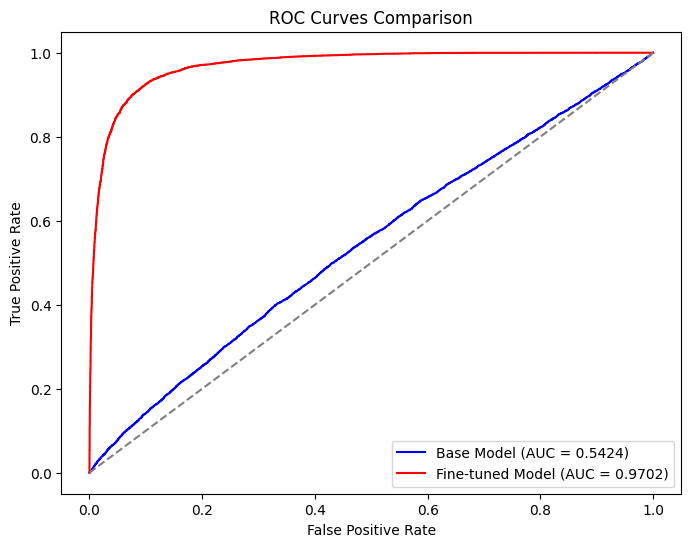

In [14]:
plot_roc_curves(base_fpr, base_tpr, ft_fpr, ft_tpr, base_auc, ft_auc)

In [16]:
# Block 9: Calculate improvement metrics
def calculate_improvements(base_preds, finetuned_preds, true_labels):
    base_accuracy = (np.array(base_preds) == np.array(true_labels)).mean()
    finetuned_accuracy = (np.array(finetuned_preds) == np.array(true_labels)).mean()

    print("\nOverall Improvements:")
    print(f"Base Model Accuracy: {base_accuracy:.4f}")
    print(f"Fine-tuned Model Accuracy: {finetuned_accuracy:.4f}")
    print(f"Absolute Improvement: {(finetuned_accuracy - base_accuracy)*100:.2f}%")

    return base_accuracy, finetuned_accuracy

# Calculate and display improvements
base_acc, ft_acc = calculate_improvements(base_preds, finetuned_preds, true_labels)


Overall Improvements:
Base Model Accuracy: 0.5020
Fine-tuned Model Accuracy: 0.9101
Absolute Improvement: 40.81%
